#**MIAMI DADE COUNTY PURCHASE ORDERS ASSESSMENT**
###Objective
Analyze the 2024 Purchase Order dataset from Miami Dade County to potentially negotiate with suppliers for better pricing opportunities. We will start with RFM methodologies in conjunction with K Means clustering to understand Miami Dade County’s recency, frequency, and monetary value before moving onto assessing Monte Carlo simulations to further strengthen negotiation strategy.

###Dataset
This dataset contains all purchases made by Miami Dade County in 2024. Included in this dataset is purchase order information such as purchase order unique identifier numbers, the amount of the purchase orders, the date of the purchase order, etc. This dataset also contains information such as item descriptions and supplier information which are vital for this analysis. There is a total of 43,058 rows and 31 columns. This dataset was taken from the Miami Dade County open-source data hub. Link: https://gis-mdc.opendata.arcgis.com/datasets/673f9be756ce4d2a95039bf16d3a3f7d_0/explore


#**Loading Data**

In [ ]:
#Importing necessary Libraries
!pip install mlxtend -qqq
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [ ]:
#Load dataset
url = "https://raw.githubusercontent.com/Perez786/Datasets/refs/heads/main/MiamiDade_PurchaseOrders_2024.csv"
df = pd.read_csv (url)
df.head(31).T

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
PO_NUMBER,1838,1772,1962,1910,1971,1978,2079,1978,1978,1795,...,1981,2080,1910,1795,1910,2080,1856,1910,2002,1795
PO_DATE,2024/02/13 05:00:00+00,2024/01/08 05:00:00+00,2024/05/01 04:00:00+00,2024/03/27 04:00:00+00,2024/05/07 04:00:00+00,2024/05/15 04:00:00+00,2024/07/16 04:00:00+00,2024/05/15 04:00:00+00,2024/05/15 04:00:00+00,2024/01/18 05:00:00+00,...,2024/05/16 04:00:00+00,2024/07/16 04:00:00+00,2024/03/27 04:00:00+00,2024/01/18 05:00:00+00,2024/03/27 04:00:00+00,2024/07/16 04:00:00+00,2024/02/29 05:00:00+00,2024/03/27 04:00:00+00,2024/05/24 04:00:00+00,2024/01/18 05:00:00+00
PO_AMOUNT,11500.0,204.0,313968.4,27.0,2335.5,1581.6,3000.0,618.6,618.6,651.0,...,77.7,1400.0,13.5,126.0,27.0,1000.0,20450.56,67.5,550.0,1143.45
PO_LINE_NUMBER,1,1,2,1,1,1,5,2,3,1,...,3,2,5,4,6,3,1,7,7,5
INVOICE_ITEM_ID,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PO_QUANTITY,46.0,1.0,4.0,2.0,10.0,30.0,1.0,15.0,15.0,10.0,...,10.0,1.0,1.0,6.0,2.0,1.0,0.818,1.0,1.0,15.0
UOM_SIZE,HRS,EA,EA,EA,EA,CS,LOT,CS,CS,EA,...,EA,LOT,EA,EA,EA,LOT,LOT,EA,EA,EA
UNIT_COST,250.0,204.0,78492.1,13.5,233.55,52.72,3000.0,41.24,41.24,65.1,...,7.77,1400.0,13.5,21.0,13.5,1000.0,25000.684,67.5,550.0,76.23
PHONE_AREA_INTL_CODE,305,786,904,305,610,845,954,845,845,386,...,386,305,305,386,305,305,305,305,305,386
PHONE_NUMBER,281-8340,237-8357,264-4502,712-6653,968-3361,782-6800,639-2827,782-6800,782-6800,418-6700,...,418-6700,471-4455,712-6653,418-6700,712-6653,471-4455,665-2820,712-6653,735-2699,418-6700


#**Structural Investigation**

In [ ]:
df.shape

(43058, 31)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43058 entries, 0 to 43057
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   PO_NUMBER              43058 non-null  int64  
 1   PO_DATE                43058 non-null  object 
 2   PO_AMOUNT              43058 non-null  float64
 3   PO_LINE_NUMBER         43058 non-null  int64  
 4   INVOICE_ITEM_ID        1 non-null      float64
 5   PO_QUANTITY            43058 non-null  float64
 6   UOM_SIZE               43058 non-null  object 
 7   UNIT_COST              43058 non-null  float64
 8   PHONE_AREA_INTL_CODE   40198 non-null  object 
 9   PHONE_NUMBER           40198 non-null  object 
 10  PHONE_EXTENSION        2697 non-null   float64
 11  SUPPLIER_ADDRESS       43058 non-null  object 
 12  CITY                   43058 non-null  object 
 13  STATE                  43049 non-null  object 
 14  POSTAL                 43058 non-null  object 
 15  CO

In [ ]:
#How many suppliers
df['SUPPLIER_NAME'].nunique()

1383

In [ ]:
#How many items
df['ITEM_DESCRIPTION'].nunique()

31069

In [ ]:
#Assessing total spent by Miami Dade County
df['PO_AMOUNT'].sum()

np.float64(2010925036.254)

In [ ]:
#Dropping unecessary columns
df = df[['SUPPLIER_NAME', 'PO_DATE', 'PO_NUMBER', 'PO_AMOUNT', 'ITEM_DESCRIPTION']]
df.head()

,SUPPLIER_NAME,PO_DATE,PO_NUMBER,PO_AMOUNT,ITEM_DESCRIPTION
0,APPLAUSE YOUR PAWS INC,2024/02/13 05:00:00+00,1838,11500.0,INDIVIDUAL CLASSES Instructor Lead Basic Train...
1,HOME ENTERTAINMENT SYSTEMS INC,2024/01/08 05:00:00+00,1772,204.0,Motorola Multi-Unit Charger - Model No. 56531 ...
2,GARBER FORD INC,2024/05/01 04:00:00+00,1962,313968.4,Tracking: ASD 2 23/24 2024 (or Newer) Ford Tra...
3,AGNI ENTERPRISES LLC,2024/03/27 04:00:00+00,1910,27.0,Economy PVC Water Boots - Color: Black - Size 4
4,ZOETIS US LLC,2024/05/07 04:00:00+00,1971,2335.5,Canine and Feline Serum Luteinizing Hormone (L...


<ipython-input-9-4774d704cdfa>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.barplot(x=unique_values.index, y=unique_values, palette='inferno')
<ipython-input-9-4774d704cdfa>:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')


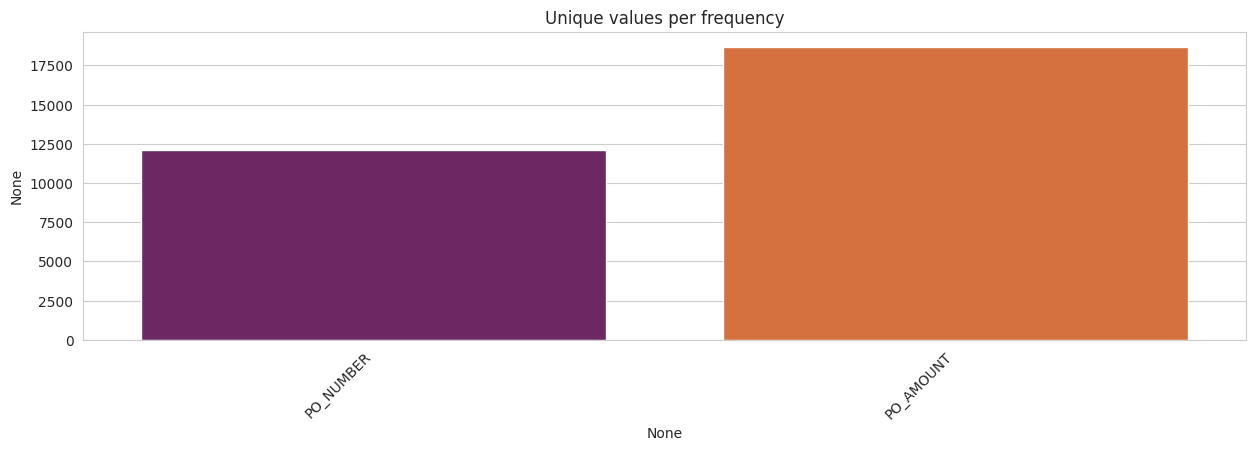

In [ ]:
#evaluation of Numeric Features
unique_values = df.select_dtypes(include='number').nunique().sort_values()
plt.figure(figsize=(15, 4))
sns.set_style('whitegrid')

g = sns.barplot(x=unique_values.index, y=unique_values, palette='inferno')
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
g.set_title('Unique values per frequency')
plt.show()

In [ ]:
#Standarizing naming conventions in 'ITEM_DESCRIPTION'
def clean_item_description(item):
    return item.strip().lower()  # Remove leading/trailing spaces and standardize to lowercase

df['ITEM_DESCRIPTION'] = df['ITEM_DESCRIPTION'].apply(clean_item_description)

In [ ]:
#Spliting items based on a delimiter (e.g., ',' or '|')
df = df.assign(ITEM_DESCRIPTION=df['ITEM_DESCRIPTION'].str.split(','))

#Explode the list into separate rows
df = df.explode('ITEM_DESCRIPTION')
df['ITEM_DESCRIPTION'] = df['ITEM_DESCRIPTION'].str.strip()  #Clean up after splitting

In [ ]:
#Creating new csv with modified data
df.to_csv('modified_dataset.csv', index=False)

In [ ]:
#downloading new csv
from google.colab import files
files.download('modified_dataset.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##**Structural Investigation Summary**
We started with 43,058 rows and 31 columns in the dataset. Seeing that we are only performing RFM and MBA analysis, we only need 5 columns: 'SUPPLIER_NAME', 'PO_DATE', 'PO_NUMBER', 'PO_AMOUNT', 'ITEM_DESCRIPTION', so the rest of the columns were dropped. 'SUPPLIER_NAME' was chosen as the unique supplier identifier because it was the only supplier identifier that didn't have any null values. There are 1,383 different suppliers and 31,069 different items.To further maintain the integrity of the structure of the dataset, the 'ITEM_DESCRIPTION' column was standardized and formatted to ensure accurate item results during further analysis.

#**RFM**
Using RFM to assess who the top suppliers are in terms of recency, frequency, and monetary metrics

In [ ]:
#Removing nulls
df.dropna(subset=['SUPPLIER_NAME'], inplace=True)
df['PO_DATE'] = pd.to_datetime(df['PO_DATE'])
df['PO_DATE'] = df['PO_DATE'].dt.date #Converting to a year/month/day format, excluding hours, minutes, seconds...
#Setting a reference date for recency calculation (one day after the latest invoice)
reference_date = df['PO_DATE'].max() + pd.Timedelta(days=1)

In [ ]:
#Verifying changes made to PO_DATE
df.head()

,SUPPLIER_NAME,PO_DATE,PO_NUMBER,PO_AMOUNT,ITEM_DESCRIPTION
0,APPLAUSE YOUR PAWS INC,2024-02-13,1838,11500.0,individual classes instructor lead basic train...
0,APPLAUSE YOUR PAWS INC,2024-02-13,1838,11500.0,cdbc credential)
1,HOME ENTERTAINMENT SYSTEMS INC,2024-01-08,1772,204.0,motorola multi-unit charger - model no. 56531 ...
2,GARBER FORD INC,2024-05-01,1962,313968.4,tracking: asd 2 23/24 2024 (or newer) ford tra...
2,GARBER FORD INC,2024-05-01,1962,313968.4,e1c mdc code ford fin: qc241 fsa code ford fin...


In [ ]:
#Verifying PO_DATE is now in datetime format
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72053 entries, 0 to 43057
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SUPPLIER_NAME     72053 non-null  object 
 1   PO_DATE           72053 non-null  object 
 2   PO_NUMBER         72053 non-null  int64  
 3   PO_AMOUNT         72053 non-null  float64
 4   ITEM_DESCRIPTION  72053 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 5.3+ MB


In [ ]:
#Computing RFM metrics for each supplier
rfm = df.groupby('SUPPLIER_NAME').agg({
    'PO_DATE': lambda x: (reference_date - x.max()).days,
    'PO_NUMBER': 'nunique',
    'PO_AMOUNT': 'sum'
}).reset_index()
rfm.columns = ['Supplier', 'Recency', 'Frequency', 'Monetary']
#Assessing the first few rows
print(rfm.head())

                        Supplier  Recency  Frequency   Monetary
0          2 PLUS ARCHITECTS INC      158          2  581500.00
1  22ND CENTURY TECHNOLOGIES INC       68          2  113750.00
2            2DO PRODUCTIONS LLC       94          1  140000.00
3          2M MOWER AND TOOL LLC        2         22  690403.34
4       360 ENERGY SOLUTIONS LLC       25          5  130986.58


In [ ]:
#Assessing top 5 suppliers by recency
top_recency = rfm.sort_values(by='Recency', ascending=True).head()

#Assessing top 5 suppliers by frequency
top_frequency = rfm.sort_values(by='Frequency', ascending=False).head()

#Assessing top 5 suppliers by monetary
top_monetary = rfm.sort_values(by='Monetary', ascending=False).head()

print("Top Suppliers by Recency:")
print(top_recency)

print("\nTop Suppliers by Frequency:")
print(top_frequency)

print("\nTop Suppliers by Monetary:")
print(top_monetary)

Top Suppliers by Recency:
                                 Supplier  Recency  Frequency    Monetary
953             PARAGON UNIFORM GROUP INC        1        134   374594.95
899  NETWORK & COMMUNICATION SERVICES INC        1         40  1315319.90
973     PETERBILT STORE SOUTH FLORIDA LLC        1        207  9319333.53
76     ALL BRAND SUPPLIES DISTRIBUTOR INC        1         76   390216.23
897               NEON SIGN SOLUTIONS INC        1          3    40358.15

Top Suppliers by Frequency:
                      Supplier  Recency  Frequency     Monetary
565           GENUINE PARTS CO        1       1152   1860316.50
1342          W W GRAINGER INC        1        340   2528907.41
165            BACHRODT FT LLC        1        309  38420744.32
572   GLADES PARTS COMPANY INC        1        217    146086.22
578         GLOBAL TRADING INC        1        208    691830.16

Top Suppliers by Monetary:
                                    Supplier  Recency  Frequency      Monetary
919       

In [ ]:
#Counting how many instances of 1 for recency
count_recency= (rfm['Recency'] == 1).sum()
print(f"Number of suppliers with Recency = 1: {count_recency}")

Number of suppliers with Recency = 1: 51


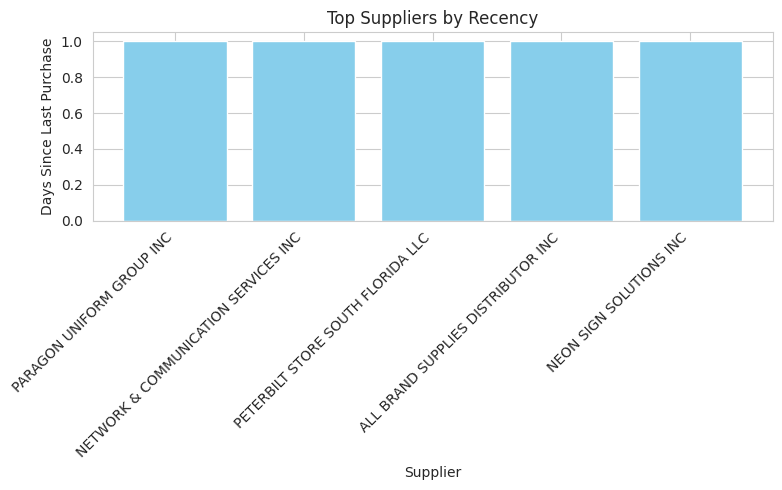

In [ ]:
#Visualizing top suppliers by recency
plt.figure(figsize=(8, 5))
plt.bar(top_recency['Supplier'], top_recency['Recency'], color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.title('Top Suppliers by Recency')
plt.xlabel('Supplier')
plt.ylabel('Days Since Last Purchase')
plt.tight_layout()
plt.show()

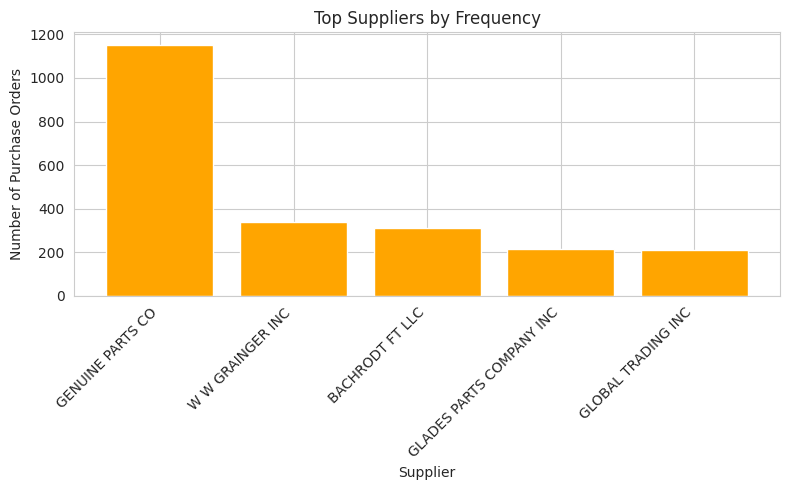

In [ ]:
#Visualizing top suppliers by frequency
plt.figure(figsize=(8, 5))
plt.bar(top_frequency['Supplier'], top_frequency['Frequency'], color='orange')
plt.xticks(rotation=45, ha='right')
plt.title('Top Suppliers by Frequency')
plt.xlabel('Supplier')
plt.ylabel('Number of Purchase Orders')
plt.tight_layout()
plt.show()

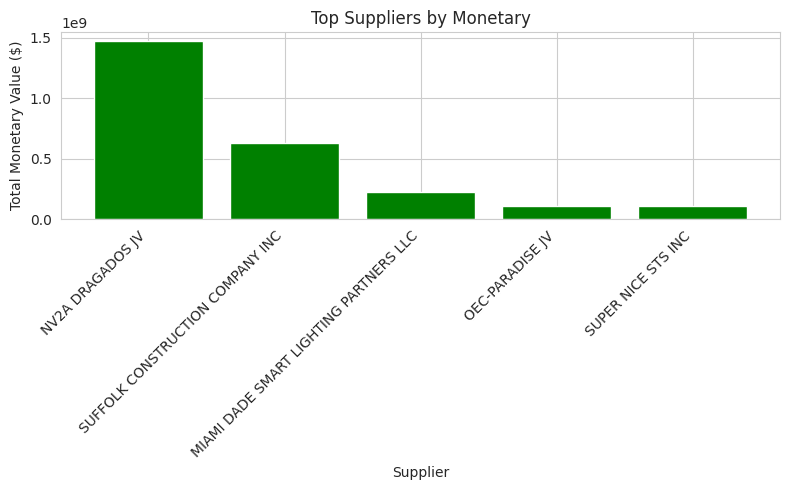

In [ ]:
#visualizing top suppliers by monetary
plt.figure(figsize=(8, 5))
plt.bar(top_monetary['Supplier'], top_monetary['Monetary'], color='green')
plt.xticks(rotation=45, ha='right')
plt.title('Top Suppliers by Monetary')
plt.xlabel('Supplier')
plt.ylabel('Total Monetary Value ($)')
plt.tight_layout()
plt.show()

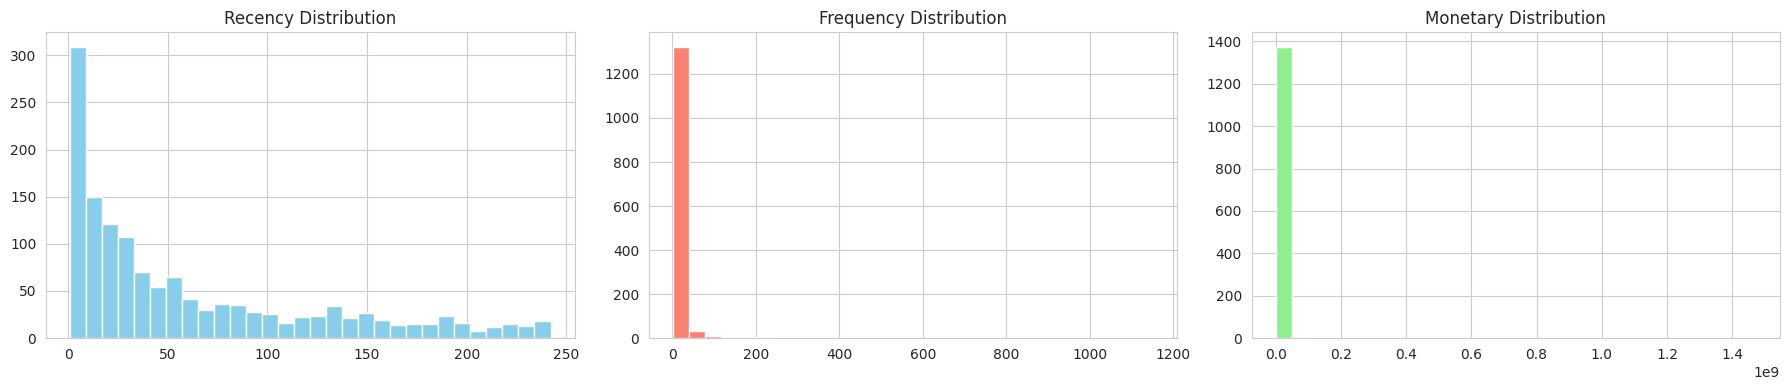

In [ ]:
#Plotting histograms for Recency, Frequency, and Monetary
fig, axes = plt.subplots(1, 3, figsize=(18, 4))
axes[0].hist(rfm['Recency'], bins=30, color='skyblue')
axes[0].set_title('Recency Distribution')
axes[1].hist(rfm['Frequency'], bins=30, color='salmon')
axes[1].set_title('Frequency Distribution')
axes[2].hist(rfm['Monetary'], bins=30, color='lightgreen')
axes[2].set_title('Monetary Distribution')
plt.tight_layout()
plt.show()

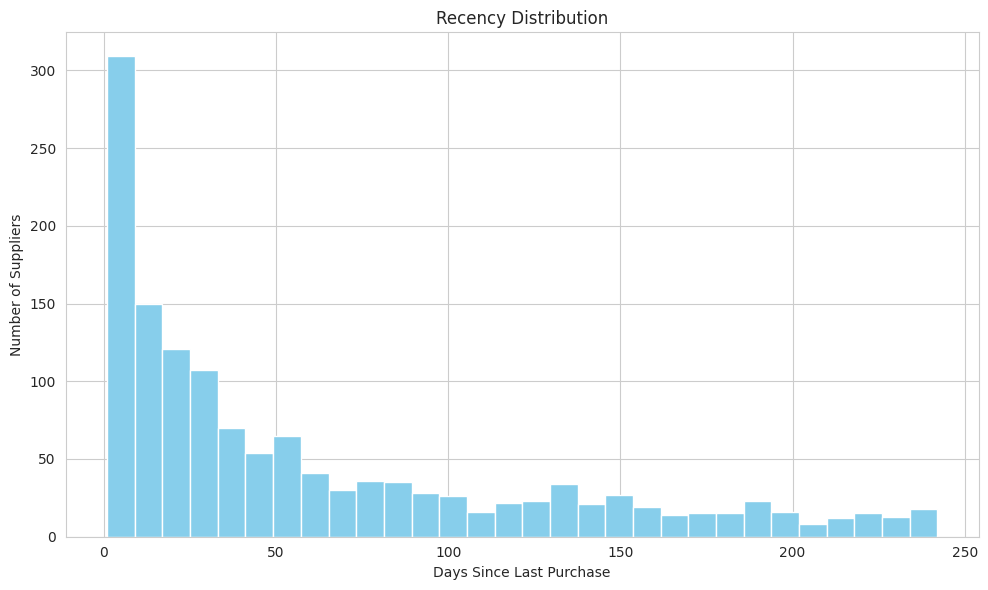

In [ ]:
#Plotting a histogram for recency
plt.figure(figsize=(10, 6))
plt.hist(rfm['Recency'], bins=30, color='skyblue')
plt.title('Recency Distribution')
plt.xlabel('Days Since Last Purchase')
plt.ylabel('Number of Suppliers')
plt.tight_layout()
plt.show()

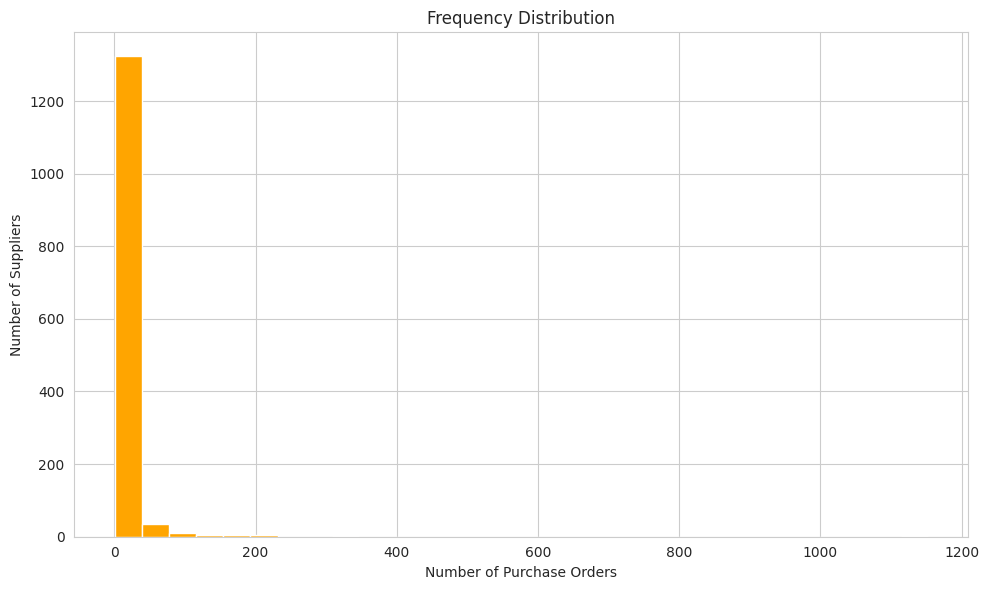

In [ ]:
#Plotting a histogram for recency
plt.figure(figsize=(10, 6))
plt.hist(rfm['Frequency'], bins=30, color='orange')
plt.title('Frequency Distribution')
plt.xlabel('Number of Purchase Orders')
plt.ylabel('Number of Suppliers')
plt.tight_layout()
plt.show()

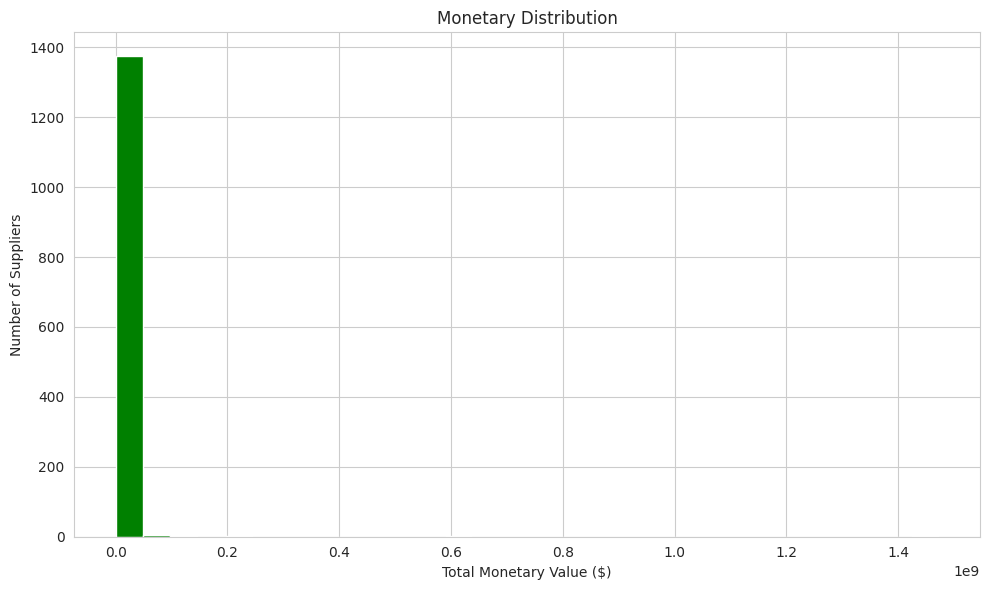

In [ ]:
#Plotting a histogram for monetary
plt.figure(figsize=(10, 6))
plt.hist(rfm['Monetary'], bins=30, color='green')
plt.title('Monetary Distribution')
plt.xlabel('Total Monetary Value ($)')
plt.ylabel('Number of Suppliers')
plt.tight_layout()

RFM Analysis Summary
According to the decreasing trend in the Recency Distribution Chart, most purchases have a low recency value, meaning Miami Dade County has purchased a good number of items recently. The long tail on the chart suggests that there are still some instances where purchases were not made recently. The low recency value tells us that we might have some potential leverage in terms of recency when negotiating with suppliers.

According to the Frequency Distribution Chart, a huge number of purchase orders are going to the same suppliers. This means potential leverage in terms of frequency when negotiating with suppliers.

According to the Monetary Distribution Chart, it seems as if most suppliers are getting paid around the same amount of money. This means there might be some opportunity here to leverage the amount of money being spent when negotiating with suppliers.

Insights after reviewing the data from the top 5 suppliers for each respective metric category (recency, frequency, and monetary):

-There are a total of 51 companies with a recency value of 1, including the top 5 frequency suppliers. This means Miami Dade County has purchased from 51 companies within a days’ time. There is not a lot to go on regarding recency alone.

-The top 5 monetary suppliers have very low frequency values, meaning Miami Dade County does not purchase from them on a regular basis. There isn’t a lot to leverage from these particular suppliers with the data we currently have.

-The top 5 frequency suppliers have a great amount of recency, frequency value, and monetary value. For the remainder of this project, we are going to analyze just the top frequency supplier, Genuine Parts Co, to see how we can make a compelling argument as to why Miami Dade County deserves better pricing.

#**K Means Clustering**
Here we will be using K Means Clustering to group data for Genuine Parts Co

In [ ]:
#Creating a new DataFrame that consists of data solely pertaining to 'Genuine Parts Co' from the 'Supplier Name' column
new_df = df[df['SUPPLIER_NAME'] == 'GENUINE PARTS CO']

In [ ]:
#Assessing new df
new_df.head()

,SUPPLIER_NAME,PO_DATE,PO_NUMBER,PO_AMOUNT,ITEM_DESCRIPTION
5049,GENUINE PARTS CO,2024-02-22,6868,20000.0,to pay for current invoices and future needs o...
5049,GENUINE PARTS CO,2024-02-22,6868,20000.0,vessel\
5049,GENUINE PARTS CO,2024-02-22,6868,20000.0,and small engine parts on as needed basis for ...
5110,GENUINE PARTS CO,2024-01-10,6614,8000.0,for the purchase automotive parts and supplies...
5113,GENUINE PARTS CO,2024-01-10,6614,20000.0,for the purchase automotive parts and supplies...


In [ ]:
#Assessing new df
new_df.shape

(3061, 5)

In [ ]:
#Computing RFM metrics for each supplier
gpc_rfm = new_df.groupby('ITEM_DESCRIPTION').agg({
    'PO_DATE': lambda x: (reference_date - x.max()).days,
    'PO_NUMBER': 'nunique',
    'PO_AMOUNT': 'sum'
}).reset_index()
gpc_rfm.columns = ['Item', 'Recency', 'Frequency', 'Monetary']
#Assessing the first few rows
print(gpc_rfm.head())

                         Item  Recency  Frequency  Monetary
0                                   26          1     43.44
1  #7151230 grease gun (500).       33          1     34.99
2  #75-600 napa grease (500).       33          1     34.95
3     #90670br coupler (630).       33          1     41.30
4        #90674br plug (630).       33          1     22.60


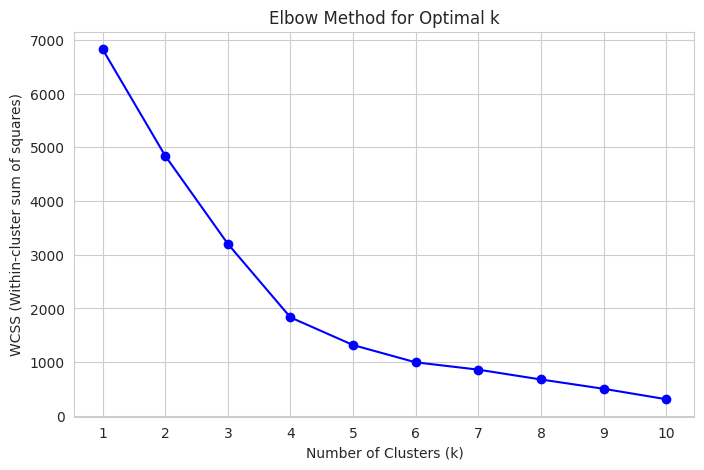

In [ ]:
#Scaling RFM
scaler = StandardScaler()
gpc_rfm_scaled = scaler.fit_transform(gpc_rfm[['Recency', 'Frequency', 'Monetary']])

#Using the Elbow Method to find the optimal number of clusters
wcss = []  # Within-cluster sum of squares
k_range = range(1, 11)  # Testing k from 1 to 10

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(gpc_rfm_scaled)
    wcss.append(kmeans.inertia_)  # Inertia is WCSS

#Plotting the Elbow Method graph
plt.figure(figsize=(8, 5))
plt.plot(k_range, wcss, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Within-cluster sum of squares)')
plt.title('Elbow Method for Optimal k')
plt.xticks(k_range)
plt.grid(True)
plt.show()

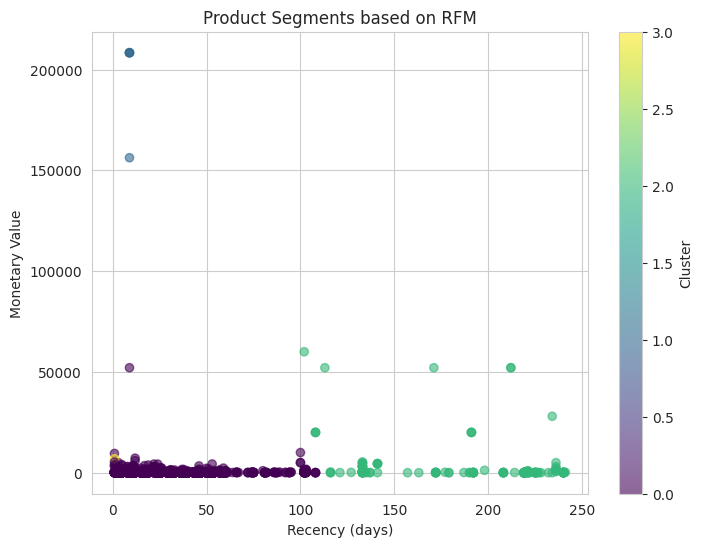

         Recency  Frequency  Monetary
Cluster                              
0           32.2        1.3     269.8
1            9.0        3.8  195317.3
2          186.1        1.0    3374.3
3            1.0       66.0    6911.7


In [ ]:
#Applying K-Means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
gpc_rfm['Cluster'] = kmeans.fit_predict(gpc_rfm_scaled)

#Visualizing clusters in a 2D scatter plot (Recency vs. Monetary)
plt.figure(figsize=(8,6))
plt.scatter(gpc_rfm['Recency'], gpc_rfm['Monetary'], c=gpc_rfm['Cluster'], cmap='viridis', alpha=0.6)
plt.xlabel('Recency (days)')
plt.ylabel('Monetary Value')
plt.title('Product Segments based on RFM')
plt.colorbar(label='Cluster')
plt.show()

#Examining cluster profiles
cluster_profile = gpc_rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).round(1)
print(cluster_profile)

In [ ]:
#Assessing items rfm
gpc_rfm.head()

,Item,Recency,Frequency,Monetary,Cluster
0,,26,1,43.44,0
1,#7151230 grease gun (500).,33,1,34.99,0
2,#75-600 napa grease (500).,33,1,34.95,0
3,#90670br coupler (630).,33,1,41.30,0
4,#90674br plug (630).,33,1,22.60,0


In [ ]:
#Assessing cluster rfm stats
clustered_stats = gpc_rfm.groupby('Cluster').describe()
print(clustered_stats)

        Recency                                                            \
          count        mean        std    min    25%    50%    75%    max   
Cluster                                                                     
0        2123.0   32.213848  22.249304    1.0   12.0   31.0   47.0  108.0   
1           4.0    9.000000   0.000000    9.0    9.0    9.0    9.0    9.0   
2         148.0  186.148649  43.261798  102.0  133.0  192.0  221.0  241.0   
3           1.0    1.000000        NaN    1.0    1.0    1.0    1.0    1.0   

        Frequency             ...             Monetary                 \
            count       mean  ...   75%   max    count           mean   
Cluster                       ...                                       
0          2123.0   1.265662  ...   1.0  23.0   2123.0     269.775827   
1             4.0   3.750000  ...   4.0   4.0      4.0  195317.325000   
2           148.0   1.006757  ...   1.0   2.0    148.0    3374.333716   
3             1.0  66.

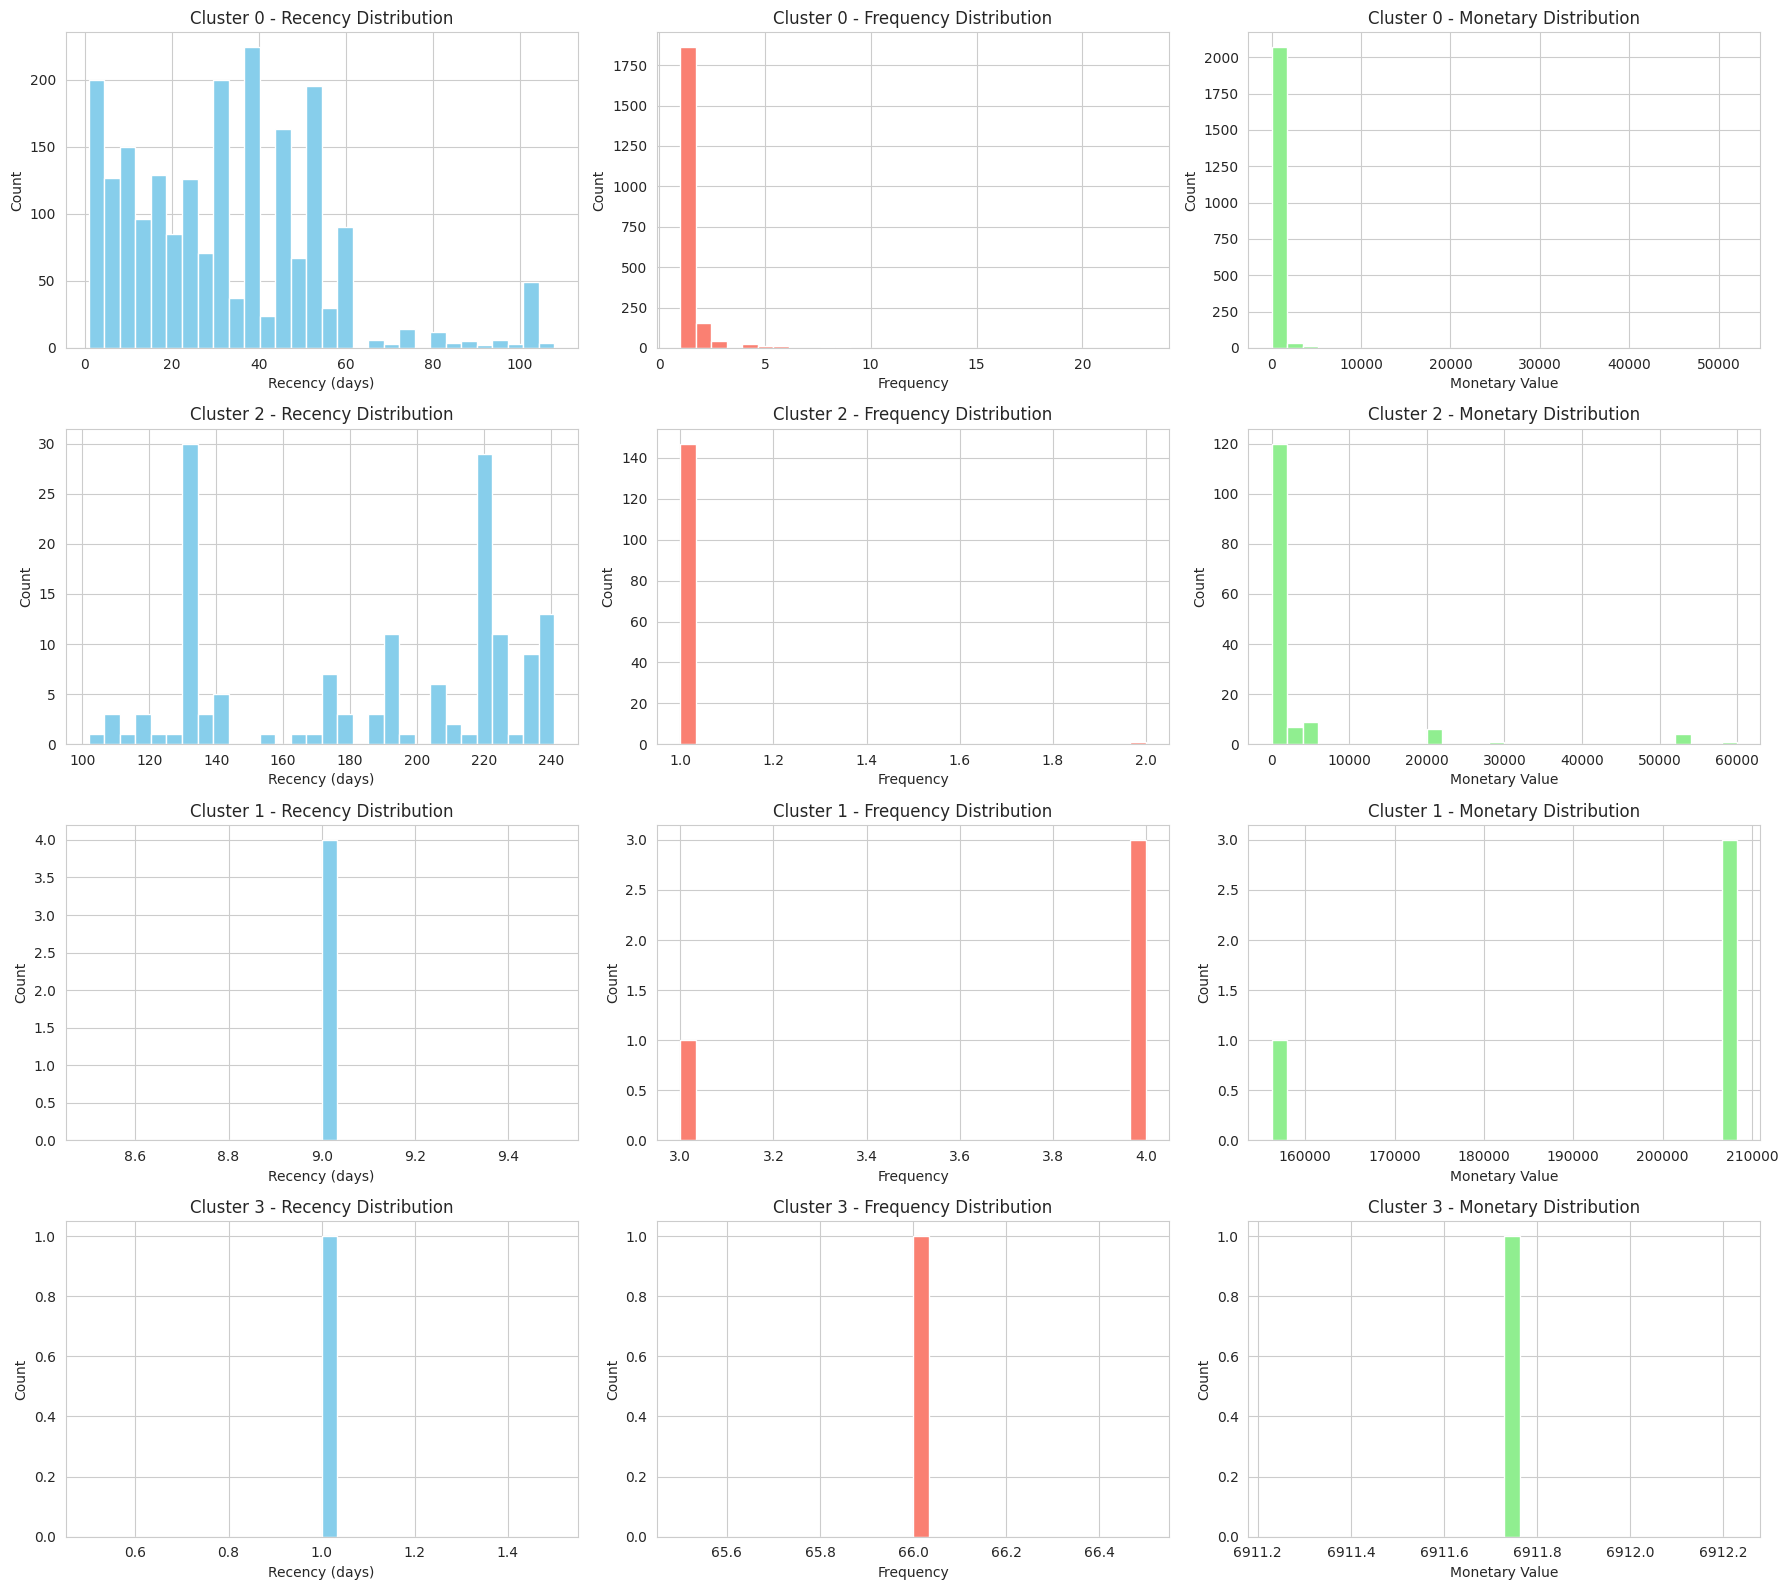

In [ ]:
#Visualizing RFM for each cluster
clusters = gpc_rfm['Cluster'].unique()
fig, axes = plt.subplots(len(clusters), 3, figsize=(18, len(clusters) * 4), sharex=False)

for i, cluster in enumerate(clusters):
    cluster_data = gpc_rfm[gpc_rfm['Cluster'] == cluster]

    #Recency Plot
    axes[i, 0].hist(cluster_data['Recency'], bins=30, color='skyblue')
    axes[i, 0].set_title(f'Cluster {cluster} - Recency Distribution')
    axes[i, 0].set_xlabel('Recency (days)')
    axes[i, 0].set_ylabel('Count')

    #Frequency Plot
    axes[i, 1].hist(cluster_data['Frequency'], bins=30, color='salmon')
    axes[i, 1].set_title(f'Cluster {cluster} - Frequency Distribution')
    axes[i, 1].set_xlabel('Frequency')
    axes[i, 1].set_ylabel('Count')

    #Monetary Plot
    axes[i, 2].hist(cluster_data['Monetary'], bins=30, color='lightgreen')
    axes[i, 2].set_title(f'Cluster {cluster} - Monetary Distribution')
    axes[i, 2].set_xlabel('Monetary Value')
    axes[i, 2].set_ylabel('Count')

#Output
plt.tight_layout()
plt.show()

In [ ]:
#Filtering the dataset for Cluster 0
cluster_0_data = gpc_rfm[gpc_rfm['Cluster'] == 0]

#Sorting by Frequency and and Recency in descending order
sorted_data = cluster_0_data.sort_values(by=['Frequency', 'Recency'], ascending=[False, False]) #[False, False] ensures descending order

#Assessing the top 10 Frequency/Recency combinations
print("Top Recency and Frequency combinations for Cluster 0 with associated Item Descriptions:")
print(sorted_data[['Item','Frequency', 'Recency', 'Monetary']].head(10))

Top Recency and Frequency combinations for Cluster 0 with associated Item Descriptions:
              Item  Frequency  Recency  Monetary
1089    air filter         23        1   9552.18
1905    oil filter         23        1   3770.41
1597   fuel filter         17        1   5271.88
788           7565         13       12   7231.12
1149       battery         10       12   5979.19
1502  front rotors          9        8   1316.78
1571        ft8855          9        4   1790.36
270           26ca          9        2   3340.80
797           7590          8       11   3029.22
1559      ft880982          8        5   3562.24


In [ ]:
cluster_0_data['Monetary'].sum()

np.float64(572734.08)

In [ ]:
#Displaying the sole item in Cluster 3
print(gpc_rfm[gpc_rfm['Cluster'] == 3]['Item'].iloc[0])

core


##**K Means Clustering Summary (Genuine Parts Co)**
The dataset was filtered so that we can re-perform RFM solely on the data from Genuine Parts Co. The newly created data frame has 3,061 rows and 5 columns. We used the elbow method to find the optimum number of clusters (4 clusters) and proceeded to apply K Means clustering to properly assign items to groups. These are the results of the cluster:

-Cluster 0: 2,123 items, Recency of 32.2, Frequency of 1.3, and Monetary of 269.8. This tells us that most items in this cluster are fairly cheap and tend to be purchased once a month (more or less). This cluster also has the greatest number of items by far.

-Cluster 1: 4 items, Recency of 9.0, Frequency of 3.8, and Monetary of 195,317.3. This tells us that these 4 items are abnormally large purchases that aren’t purchased too often.

-Cluster 2: 148 items, Recency of 186.1, Frequency of 1.0, and Monetary of 3,374.3. This tells us that these items are items that aren’t purchased often as the recency is the highest out of all clusters, the frequency is the lowest, and it has the 2nd least monetary value.

-Cluster 3: 1 item, Recency of 1.0, Frequency of 66.0, and Monetary of 6,911.7. This tells us that this 1 item gets purchased a lot as it has the highest frequency and the lowest recency.

After reviewing all the data regarding clustering, it is safe to assume that Clusters 0 and 3 are clear candidates for bargaining due to their frequency and recency values. Whether or not the other clusters are also qualified for bargaining is at the discretion of an expert in the area. Cluster 3’s sole item is a core that gets purchased 66 times a year with a high recency value and a monetary value of $6,911.70. Cluster 0 has 2,123 items with some of those items having low recency and high frequency values.

#**Monte Carlo Analysis**
This Monte Carlo analysis is meant to predict what spending would be next year to show suppliers the potential amount of money Miami Dade would be spending if Miami Dade were to continue business operations with them and what they would be losing if there is not a deal to be made.

In [ ]:
#Assessing the total amount spent on Genuine Parts Co products
gpc_rfm['Monetary'].sum()

np.float64(1860316.5)

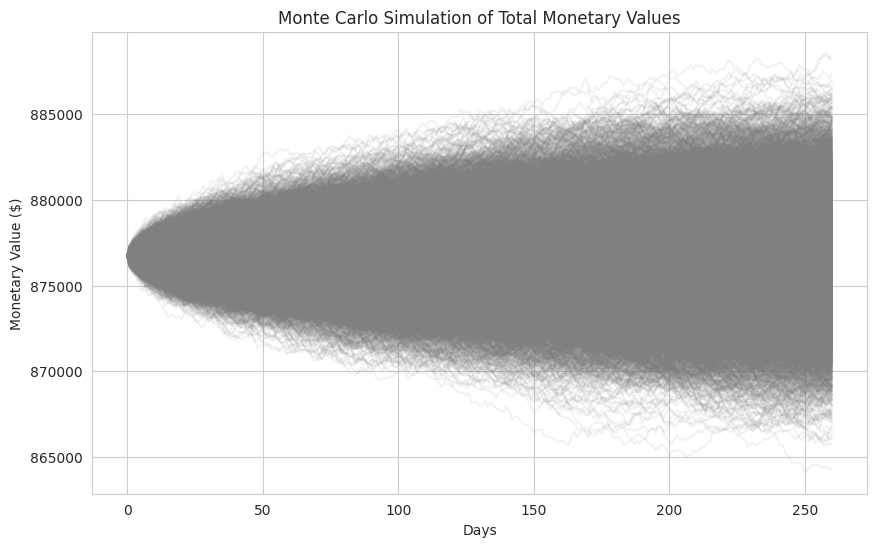

In [ ]:
#Implementing Monte Carlo Simulation

num_simulations = 10000  #10,000 simulation runs
num_days = 260  #Number of business days in a year

#Creating random simulation data
simulation_results = []
for _ in range(num_simulations):
    base_value = 876747.18 #Monetary total
    daily_changes = np.random.normal(loc=0, scale=200, size=num_days)  #Random daily fluctuations
    simulation = np.cumsum(np.insert(daily_changes, 0, base_value))  #Cumulative sum for simulation
    simulation_results.append(simulation)

#Creating an array for simulation results
simulation_results = np.array(simulation_results)

#Plotting simulation results
plt.figure(figsize=(10, 6))

#Plotting each simulation run
for simulation in simulation_results:
    plt.plot(simulation, color='grey', alpha=0.1)

#Visualizing data
plt.title('Monte Carlo Simulation of Total Monetary Values')
plt.xlabel('Days')
plt.ylabel('Monetary Value ($)')
plt.grid(True)

plt.show()


In [ ]:
#Computing total monetary value and confidence interval

#Calculating the mean of the monetary value
mean_simulated_value = np.mean(simulation_results[-1, :])

#Calculating the 95% confidence interval
conf_interval_95 = np.percentile(simulation_results[-1, :], [2.5, 97.5])

#Output
print(f'Expected value after {num_days} days: ${mean_simulated_value:.2f}')
print(f'95% confidence interval: ${conf_interval_95[0]:.2f} - ${conf_interval_95[1]:.2f}')

Expected value after 260 days: $875258.86
95% confidence interval: $872690.69 - $877003.65


##**Monte Carlo Analysis Summary**
Miami Dade County spent 876,747.18 at Genuine Parts Co in 2024. Using this amount as the base value, we ran 10,000 Monte Carlo simulations over the course of a business year (260 days). The expected value came out to 875,258.86 and a 95% confidence interval of 872,690.69 - 877,003.65. Yes, deals and discounts will lower this amount, but Genuine Parts Co still has a large amount of money to make, and a bigger amount to lose if Miami Dade were to go with another company.

#**Project Summary**
According to the data, Miami Dade County spent 4,288,751,653.82 in 2024 on 43,058 transactions (31,069 distinctly different items) with 1,383 different suppliers. Using RFM we were able to gain insights as to where the money is going, how often, and how recent. Miami Dade County can use this data to possibly negotiate with suppliers to get better pricing options, given the vast spending capabilities of the county. We used the supplier Genuine Parts Co as an example of how you can use K Means Clustering to group items for strategical positioning when negotiating. Furthermore, we used a Monte Carlo analysis to show the potential spending capabilities of Miami Dade County for next year to emphasize the value Miami Dade County has to offer their business.

After assessing Genuine Parts Co’s relationship with Miami Dade County, we were able to see that MDC (Miami Dade County) spent a total of 876,747.18 at GPC (Genuine Parts Co). Based on the data, we were able to estimate that MDC will spend 875,258.86 in total for 2025, with the least possible amount being 872,690.69 and the highest possible amount being 877,003.65. Using RFM in conjunction with K Means Clustering we were able to see two out of four clusters with potential for negotiations based on hypothetical criteria (essentially, the higher the frequency and recency, the more leverage MDC has in purchasing power with frequently purchased items). There is a possibility that all four clusters have potential for negotiations, but that would have to be determined by an expert on the matter.

 Cluster 0 has a monetary value of 572,734.08 and Cluster 3 has a monetary value of 6,911.73. Developing criteria for negotiations without being an expert in the field presents its challenges, but in this scenario, we are going to go with hypothetical thresholds and present recommendations to show an example of how this data can be used to possibly negotiate with GNC:

-MDC can ask for some type of overall discount for the expected 875,258.86 that MDC will be spending with GNC in 2025.

-MDC can request discounts be applied in brackets. For instance, when crossing the 100k threshold, there will be a 10% discount applied, when crossing the 300k threshold a 5% discount will be applied, etc.

-Cluster 0 has a monetary value of 572,734.08. Maybe an overall discount can be applied to all items in this cluster as it has a significant amount of monetary value?

-Cluster 3 has a monetary value of 6,911.73 for 1 item, a core, that was purchased 66 times in 2024.  This one item could possibly be an item that receives a discount as it is purchased pretty frequently.

-Bargain with items within Cluster 0 that have a high frequency/recency combination. For instance, if the frequency of an item is 12 or more (indicating this item has been purchased 12 times within the year) and has a recency threshold of at least 30 or less (indicating it has been at least 30 days since the last purchase), we can assume that these items are being purchased monthly at the very least. With this information, MDC can request monthly discounts on these items. In this example, we were able to see 4 items that met that criterion: air filters (9,552.18), oil filters (3,770.41), fuel filters (5,271.88), and 7565 (7,231.12) for a total of 25,825.59.

In conclusion, this type of overall analysis can be run on any supplier in the dataset and can be used as a bargaining tool to negotiate better pricing. Getting better pricing can result in MDC saving potentially hundreds of thousands of dollars, maybe more depending on negotiations, that can be allocated for other county projects. This information can possibly also leverage negotiations with competing suppliers to attain better pricing if MDC’s current suppliers do not wish to negotiate.


#**Further Analysis**